<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/Test_exact_gpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

Populating the interactive namespace from numpy and matplotlib


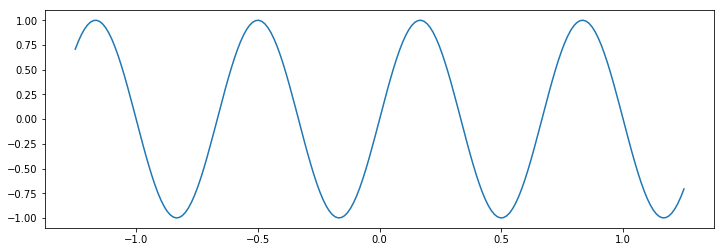

In [24]:
# test matplot
plt.figure(figsize=(12,4))
x=np.linspace(-1.25,1.25,200)
y= np.sin(3*np.pi*x)
plt.plot(x,y)
plt.show()

In [25]:
sess=tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
# generate training data
# parameters
num_training_points=100
obs_noise_var=0.1

# generate x and y
ind_points=np.random.uniform(-1,1,(num_training_points,1)).astype(np.float64)
# a[...,0] selects the first elements in the last dimension of a multidimensional array
y= np.sin(3*np.pi*ind_points[...,0])
obs=y+np.random.normal(loc=0,scale=np.sqrt(obs_noise_var),size=num_training_points)

In [0]:
# generate training variable
# a - amplitude
# ls - length scale
# obs_nv - observation noise variance
# these variables will be optimized during the training

# finfo : Machine limits for floating point types
# tiny : The smallest positive usable numbe
# softplus: a smooth approximation of a rectifier 
# rectifier(x) = max(0,x)
# softplus(x) = log(1+exp(x))
tiny=np.finfo(np.float64).tiny

a_variable=tf.Variable(initial_value=1,name="amplitude",dtype=np.float64)
a=(tiny + tf.nn.softplus(a_variable))

ls_variable=tf.Variable(initial_value=1,name="length_scale",dtype=np.float64)
ls=(tiny + tf.nn.softplus(ls_variable))

obs_nv_variable=tf.Variable(initial_value=1,name="observation_noise_variance",dtype=np.float64)
obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))

In [0]:
# use Exponentiated quadratic kernel
# or could be called squared exponential, Gaussian, or radial basis function
# k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
kernel = tfk.ExponentiatedQuadratic( a, ls )

# creat GP prior distribtion
gp=tfd.GaussianProcess(kernel=kernel, index_points=ind_points, observation_noise_variance=obs_nv)

# log likelihood for obseration, the goal is to maximize it
log_likelihood=gp.log_prob(obs)

# define optimizer
optimizer=tf.train.AdamOptimizer(learning_rate=0.1)
train_op=optimizer.minimize(-log_likelihood)

In [29]:
# optimize the model parameters
sess.run(tf.global_variables_initializer())
likelis=[]

num_iters=1000
for i in range(num_iters):
  _,likeli=sess.run([train_op,log_likelihood])
  likelis.append(likeli)
  
# the results of training
[a_,ls_,obs_nv_]=sess.run([a,ls,obs_nv])
print("Training results:")
print("amplitude = %.2f" % a_)
print("lengthscale = %.2f" % ls_)
print("observation_noise_variance = %.2f" % obs_nv_)

Training results:
amplitude = 0.91
lengthscale = 0.18
observation_noise_variance = 0.12


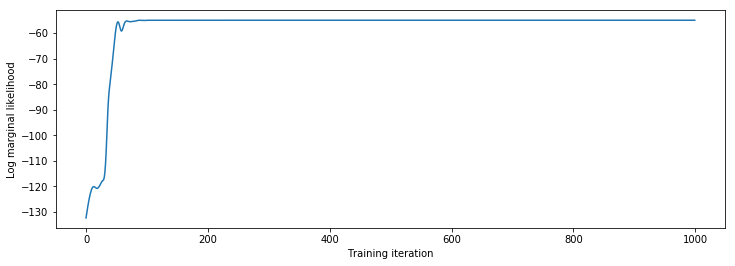

In [30]:
# plot the loss function (likelihood)
plt.figure(figsize=(12, 4))
plt.plot(likelis)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [0]:
# sample from the posterior after training
new_x=np.linspace(-1.25,1.25,200,dtype=np.float64)
new_x=new_x[...,np.newaxis]

# use Gaussian process regression model
# with the same trained kernel
gpr=tfd.GaussianProcessRegressionModel(kernel=kernel,index_points=new_x,
                                       observation_index_points=ind_points,observations=obs,
                                       observation_noise_variance=obs_nv,predictive_noise_variance=0)

# draw 50 samples
num_samples=50
samples=gpr.sample(num_samples)
samples_=sess.run(samples)

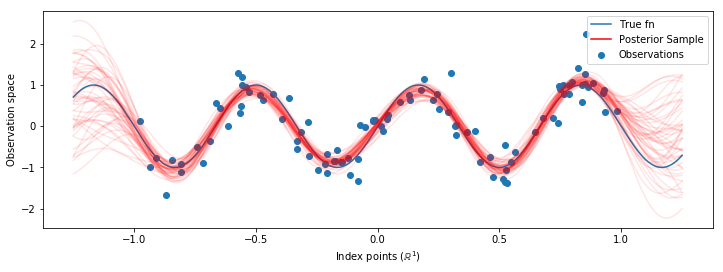

In [32]:
# plot all
plt.figure(figsize=(12, 4))

# the real function
plt.plot(new_x, np.sin(3*np.pi*new_x), label='True fn')

# the observation
plt.scatter(ind_points[:, 0], obs, label='Observations')

# the samples
for i in range(num_samples):
  plt.plot(new_x, samples_[i, :], c='r', alpha=.1, label='Posterior Sample' if i == 0 else None)

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()